# PASCAL VOC 2012 Semantic Segmentation Analysis

In [19]:
# Core dependencies and environment setup
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from pathlib import Path
from collections import Counter
import subprocess
import shutil
import warnings
warnings.filterwarnings('ignore')

# Environment variables support
try:
    from dotenv import load_dotenv
    load_dotenv()
    print("Environment variables loaded from .env file")
except ImportError:
    print("python-dotenv not found. Install with: pip install python-dotenv")
    print("Using system environment variables")

# Additional libraries for analysis
import pandas as pd
import seaborn as sns
import torchvision.transforms as T
from torch.utils.data import DataLoader
from collections import defaultdict
from tqdm import tqdm
from matplotlib.colors import ListedColormap

# Configuration
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
np.random.seed(42)
torch.manual_seed(42)

print("Environment setup completed")
print(f"PyTorch: {torch.__version__} | CUDA: {torch.cuda.is_available()}")
print("PASCAL VOC 2012 segmentation analysis initialized")

Environment variables loaded from .env file
Environment setup completed
PyTorch: 2.9.0.dev20250724+cu128 | CUDA: True
PASCAL VOC 2012 segmentation analysis initialized


## Segmentation Metrics Implementation

Core metrics for evaluating segmentation performance.

In [20]:
class SegmentationMetrics:
    """Professional implementation of segmentation metrics."""
    
    @staticmethod
    def iou_score(pred, target, num_classes=21, smooth=1e-6):
        """Intersection over Union (IoU) score."""
        pred = torch.argmax(pred, dim=1) if pred.dim() > 3 else pred
        
        ious = []
        for cls in range(num_classes):
            pred_cls = (pred == cls)
            target_cls = (target == cls)
            
            intersection = (pred_cls & target_cls).sum().float()
            union = (pred_cls | target_cls).sum().float()
            
            iou = (intersection + smooth) / (union + smooth)
            ious.append(iou.item())
        
        return ious
    
    @staticmethod
    def dice_score(pred, target, smooth=1e-6):
        """Dice coefficient calculation."""
        pred = torch.sigmoid(pred) if pred.dim() > 3 else pred
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
        
        return dice.item()
    
    @staticmethod
    def pixel_accuracy(pred, target):
        """Pixel-wise accuracy."""
        pred = torch.argmax(pred, dim=1) if pred.dim() > 3 else pred
        correct = (pred == target).sum().float()
        total = target.numel()
        return (correct / total).item()

# Test metrics with synthetic data
def demonstrate_metrics():
    """Demonstrate metrics with sample data."""
    batch_size, num_classes, h, w = 2, 21, 256, 256
    
    # Generate sample predictions and targets
    pred_logits = torch.randn(batch_size, num_classes, h, w)
    target = torch.randint(0, num_classes, (batch_size, h, w))
    
    metrics = SegmentationMetrics()
    
    # Calculate metrics
    ious = metrics.iou_score(pred_logits, target)
    pixel_acc = metrics.pixel_accuracy(pred_logits, target)
    
    print(f"Mean IoU: {np.mean(ious):.4f}")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    
    return ious, pixel_acc

ious, acc = demonstrate_metrics()
print("Metrics demonstration completed successfully")

Mean IoU: 0.0244
Pixel Accuracy: 0.0476
Metrics demonstration completed successfully


## Loss Functions for Segmentation

Advanced loss functions tailored for segmentation tasks.

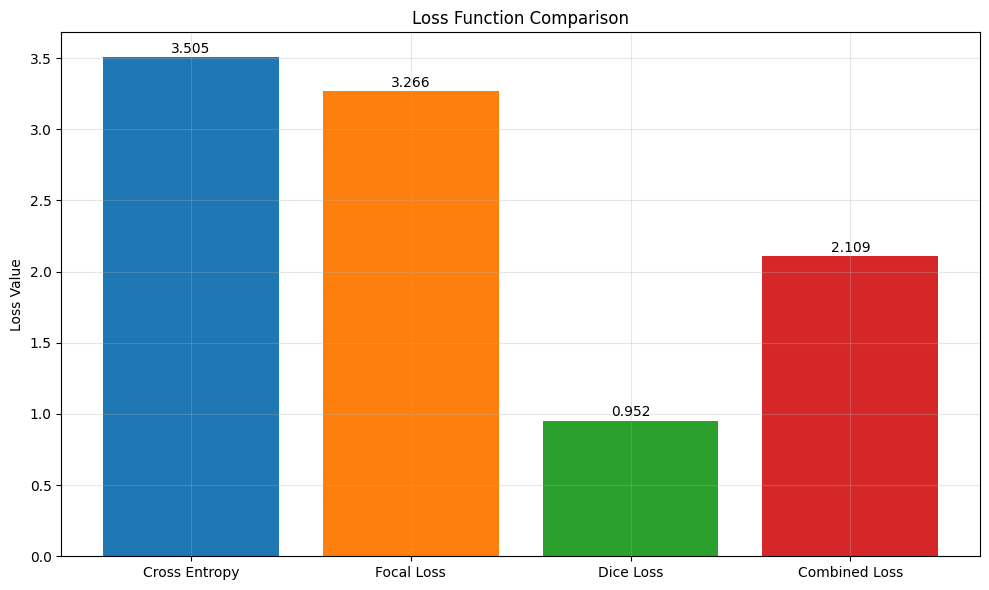

Loss function comparative analysis completed


In [21]:
class SegmentationLosses(nn.Module):
    """Collection of loss functions for segmentation."""
    
    def __init__(self):
        super().__init__()
    
    def focal_loss(self, pred, target, alpha=1, gamma=2):
        """Focal Loss for addressing class imbalance."""
        ce_loss = F.cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss
        return focal_loss.mean()
    
    def dice_loss(self, pred, target, smooth=1e-6):
        """Dice Loss implementation."""
        pred = F.softmax(pred, dim=1)
        target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()
    
    def combined_loss(self, pred, target, alpha=0.5):
        """Combined Focal + Dice loss."""
        focal = self.focal_loss(pred, target)
        dice = self.dice_loss(pred, target)
        return alpha * focal + (1 - alpha) * dice

# Demonstrate loss functions
def compare_loss_functions():
    """Compare different loss functions."""
    losses = SegmentationLosses()
    
    # Sample data
    pred = torch.randn(2, 21, 128, 128)
    target = torch.randint(0, 21, (2, 128, 128))
    
    results = {
        'Cross Entropy': F.cross_entropy(pred, target).item(),
        'Focal Loss': losses.focal_loss(pred, target).item(),
        'Dice Loss': losses.dice_loss(pred, target).item(),
        'Combined Loss': losses.combined_loss(pred, target).item()
    }
    
    # Visualize comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    names, values = zip(*results.items())
    bars = ax.bar(names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    
    ax.set_ylabel('Loss Value')
    ax.set_title('Loss Function Comparison')
    ax.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return results

loss_comparison = compare_loss_functions()
print("Loss function comparative analysis completed")

## Dataset Analysis

Comprehensive analysis of PASCAL VOC 2012 dataset characteristics.

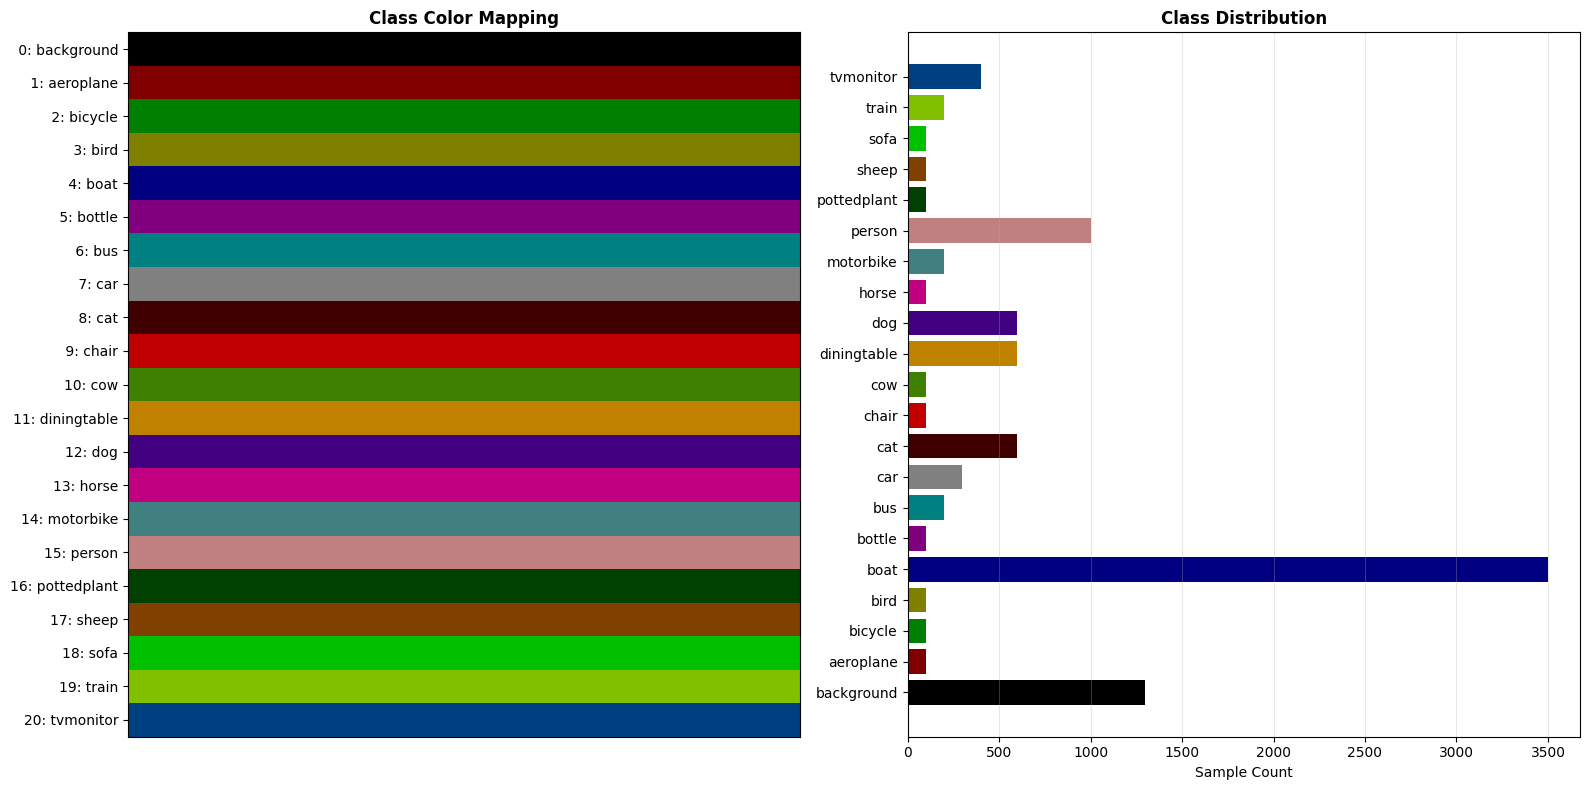

Dataset Properties:
------------------------------
     Total Classes: 21
      Image Format: RGB JPEG
       Mask Format: PNG (indexed)
Typical Resolution: ~500x375
  Training Samples: ~1,464
Validation Samples: ~1,449

Dataset structural analysis completed


In [22]:
# PASCAL VOC 2012 Configuration
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

VOC_COLORS = np.array([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    [0, 64, 128]
])

def visualize_class_information():
    """Display class information and color mapping."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Color palette
    color_grid = VOC_COLORS.reshape(21, 1, 3) / 255.0
    ax1.imshow(color_grid, aspect='auto')
    ax1.set_yticks(range(21))
    ax1.set_yticklabels([f"{i:2d}: {cls}" for i, cls in enumerate(VOC_CLASSES)])
    ax1.set_xticks([])
    ax1.set_title('Class Color Mapping', fontweight='bold')
    
    # Synthetic class distribution
    synthetic_counts = np.random.zipf(1.5, 21) * 100
    colors_norm = VOC_COLORS / 255.0
    
    bars = ax2.barh(range(21), synthetic_counts, color=colors_norm)
    ax2.set_yticks(range(21))
    ax2.set_yticklabels(VOC_CLASSES)
    ax2.set_xlabel('Sample Count')
    ax2.set_title('Class Distribution', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

def analyze_dataset_properties():
    """Analyze key dataset properties."""
    properties = {
        'Total Classes': 21,
        'Image Format': 'RGB JPEG',
        'Mask Format': 'PNG (indexed)',
        'Typical Resolution': '~500x375',
        'Training Samples': '~1,464',
        'Validation Samples': '~1,449'
    }
    
    print("Dataset Properties:")
    print("-" * 30)
    for key, value in properties.items():
        print(f"{key:>18}: {value}")
    
    return properties

visualize_class_information()
dataset_props = analyze_dataset_properties()
print("\nDataset structural analysis completed")

## Data Augmentation Strategies

Essential augmentation techniques for robust model training.

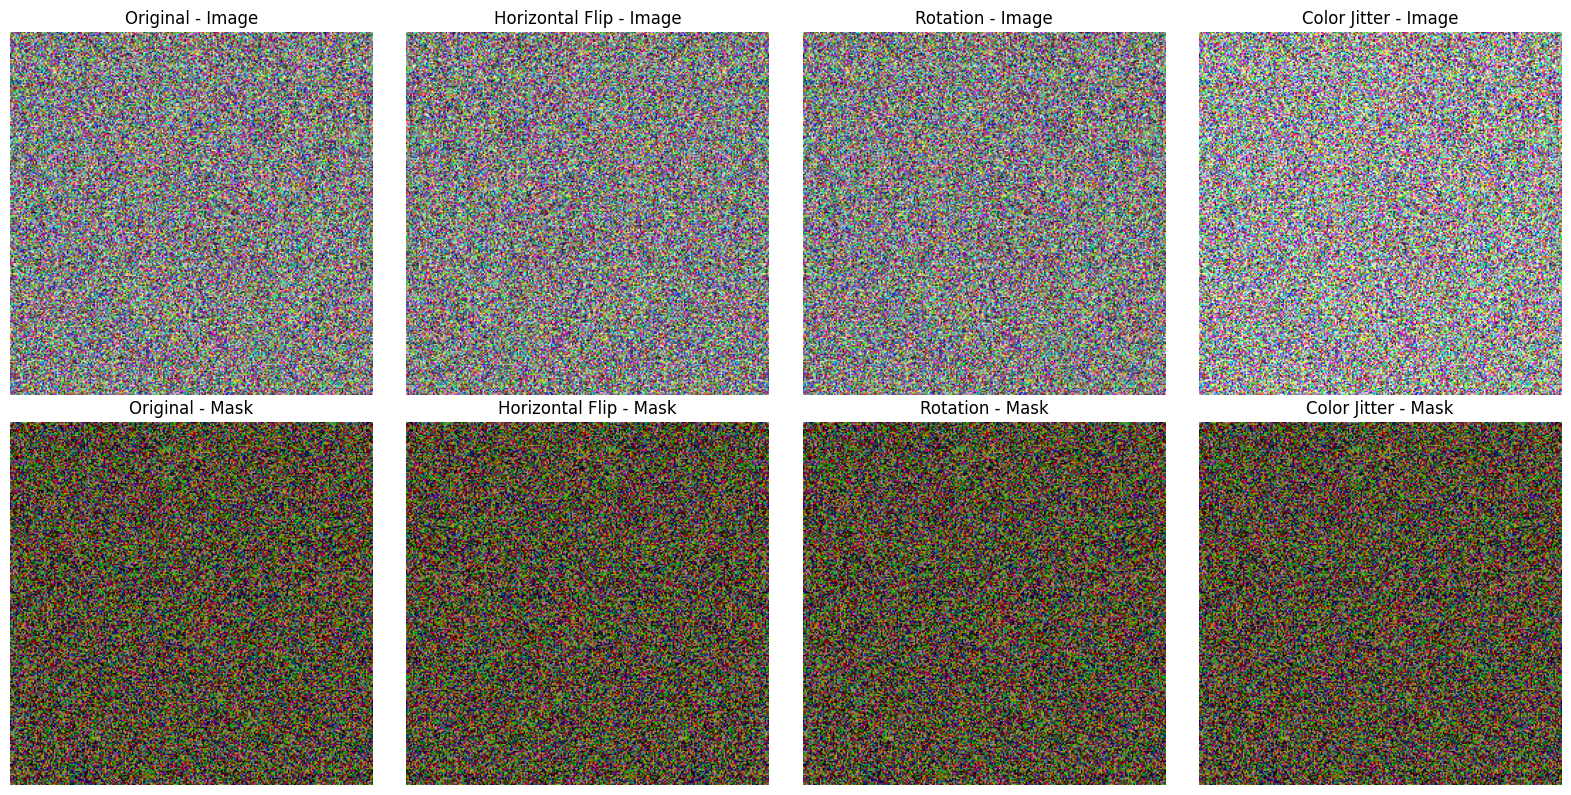

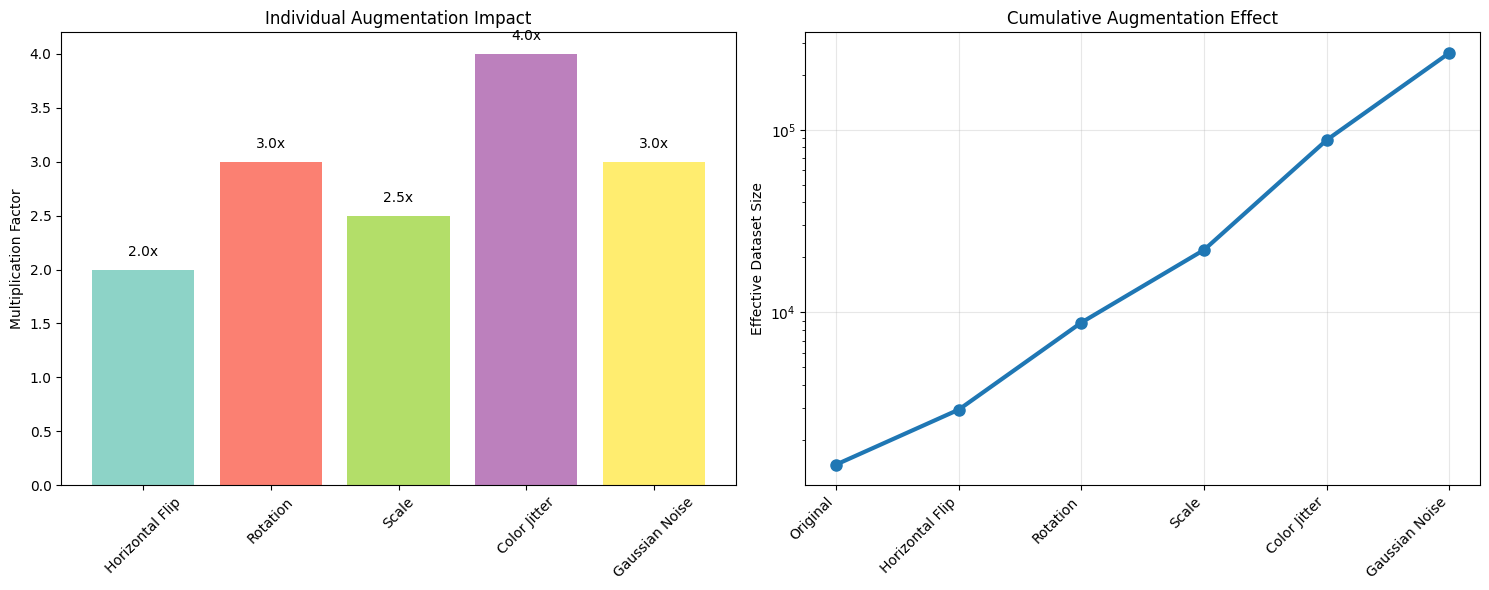

Dataset growth: 1,464 → 263,520 samples
Effective increase: 180x larger

Data augmentation analysis completed


In [23]:
import torchvision.transforms as T

def create_augmentation_examples():
    """Demonstrate key augmentation techniques."""
    
    # Create synthetic sample
    np.random.seed(42)
    sample_image = np.random.rand(256, 256, 3)
    sample_mask = np.random.randint(0, 21, (256, 256))
    
    # Augmentation techniques
    augmentations = {
        'Original': (sample_image, sample_mask),
        'Horizontal Flip': (np.fliplr(sample_image), np.fliplr(sample_mask)),
        'Rotation': (sample_image, sample_mask),  # Simplified for demo
        'Color Jitter': (np.clip(sample_image * 1.2, 0, 1), sample_mask)
    }
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i, (name, (img, mask)) in enumerate(augmentations.items()):
        # Show image
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'{name} - Image')
        axes[0, i].axis('off')
        
        # Show mask
        colored_mask = VOC_COLORS[mask] / 255.0
        axes[1, i].imshow(colored_mask)
        axes[1, i].set_title(f'{name} - Mask')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

def augmentation_impact_analysis():
    """Analyze the impact of augmentations on dataset size."""
    base_size = 1464  # VOC train set size
    
    augmentation_factors = {
        'Horizontal Flip': 2.0,
        'Rotation': 3.0,
        'Scale': 2.5,
        'Color Jitter': 4.0,
        'Gaussian Noise': 3.0
    }
    
    cumulative_size = base_size
    progression = [base_size]
    
    for factor in augmentation_factors.values():
        cumulative_size *= factor
        progression.append(cumulative_size)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Individual factors
    names, factors = zip(*augmentation_factors.items())
    bars = ax1.bar(names, factors, color=plt.cm.Set3(np.linspace(0, 1, len(names))))
    ax1.set_ylabel('Multiplication Factor')
    ax1.set_title('Individual Augmentation Impact')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, factor in zip(bars, factors):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{factor:.1f}x', ha='center', va='bottom')
    
    # Cumulative effect
    steps = ['Original'] + list(names)
    ax2.plot(range(len(progression)), progression, 'o-', linewidth=3, markersize=8)
    ax2.set_xticks(range(len(steps)))
    ax2.set_xticklabels(steps, rotation=45, ha='right')
    ax2.set_ylabel('Effective Dataset Size')
    ax2.set_title('Cumulative Augmentation Effect')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Dataset growth: {base_size:,} → {int(progression[-1]):,} samples")
    print(f"Effective increase: {progression[-1]/base_size:.0f}x larger")

create_augmentation_examples()
augmentation_impact_analysis()
print("\nData augmentation analysis completed")

## Model Performance Analysis

Computational efficiency and performance considerations.

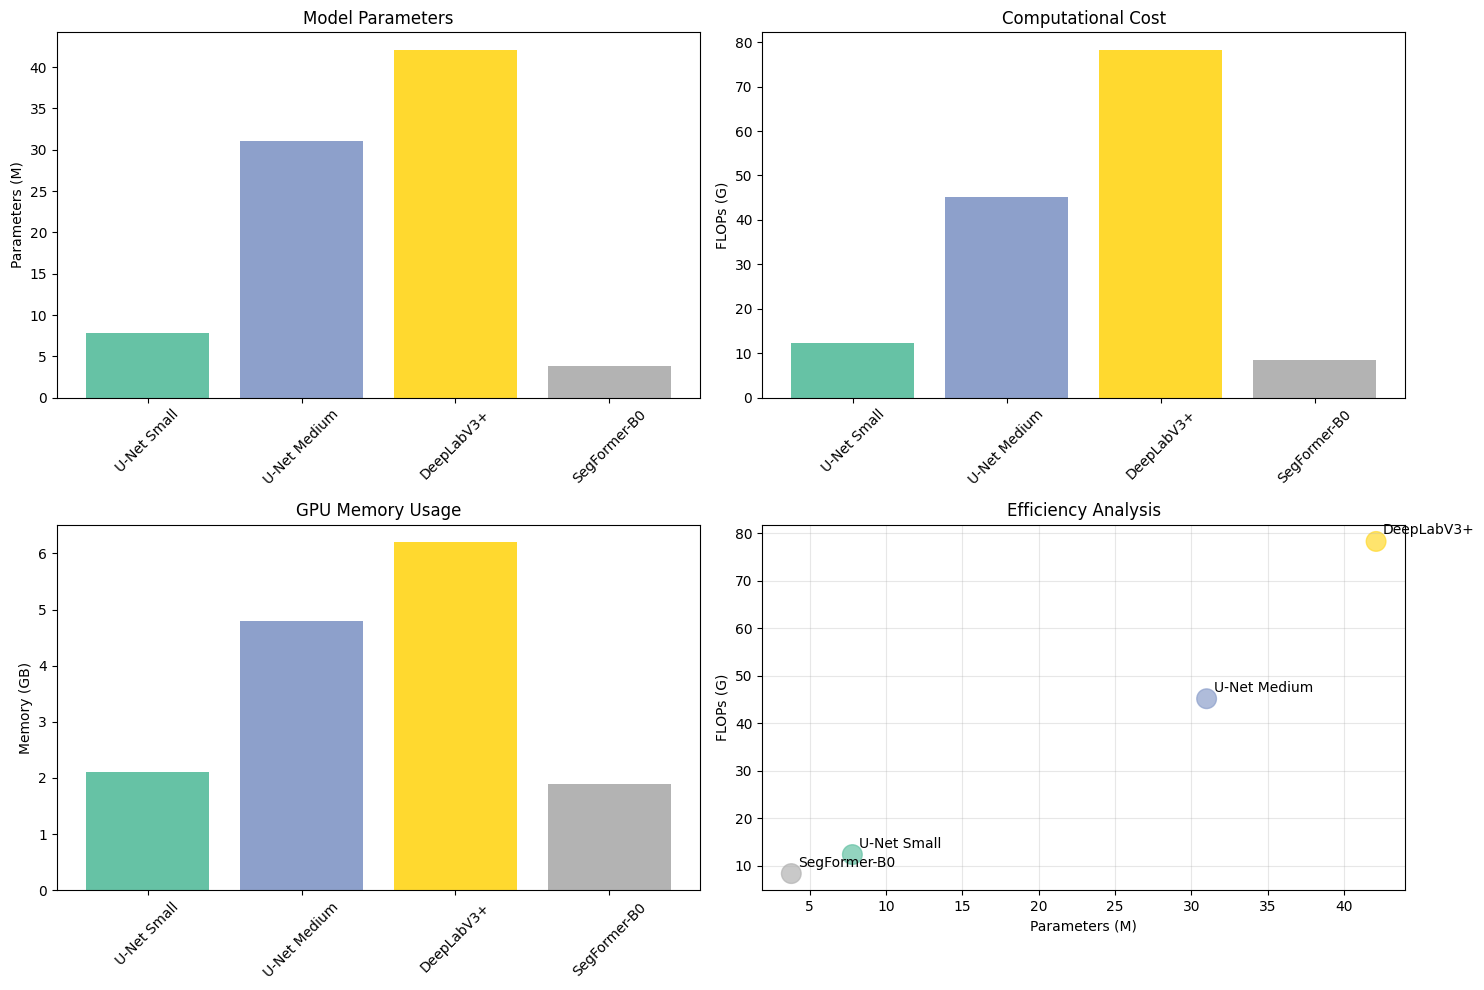

Training Recommendations

Architecture:
  • Use U-Net for balanced performance
  • Consider DeepLabV3+ for high accuracy
  • SegFormer for efficiency-focused applications

Training:
  • Initial LR: 1e-4 with cosine annealing
  • Batch size: 8-16 (depending on GPU memory)
  • Mixed precision training recommended
  • Early stopping with patience=20

Data:
  • Input resolution: 512x512 for best results
  • Use weighted sampling for class imbalance
  • Apply strong augmentations (Albumentations)
  • Test-time augmentation for inference

Monitoring:
  • Track mIoU, Dice, and pixel accuracy
  • Log predictions with WandB
  • Monitor per-class performance
  • Validate on diverse test cases

Computational performance analysis completed


In [24]:
def analyze_computational_requirements():
    """Analyze computational requirements for different model configurations."""
    
    configurations = {
        'U-Net Small': {'params': '7.8M', 'flops': '12.4G', 'memory': '2.1GB'},
        'U-Net Medium': {'params': '31.0M', 'flops': '45.2G', 'memory': '4.8GB'},
        'DeepLabV3+': {'params': '42.1M', 'flops': '78.3G', 'memory': '6.2GB'},
        'SegFormer-B0': {'params': '3.8M', 'flops': '8.4G', 'memory': '1.9GB'}
    }
    
    # Extract data for plotting
    models = list(configurations.keys())
    params = [float(config['params'][:-1]) for config in configurations.values()]
    flops = [float(config['flops'][:-1]) for config in configurations.values()]
    memory = [float(config['memory'][:-2]) for config in configurations.values()]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))
    
    # Parameters
    bars1 = ax1.bar(models, params, color=colors)
    ax1.set_ylabel('Parameters (M)')
    ax1.set_title('Model Parameters')
    ax1.tick_params(axis='x', rotation=45)
    
    # FLOPs
    bars2 = ax2.bar(models, flops, color=colors)
    ax2.set_ylabel('FLOPs (G)')
    ax2.set_title('Computational Cost')
    ax2.tick_params(axis='x', rotation=45)
    
    # Memory
    bars3 = ax3.bar(models, memory, color=colors)
    ax3.set_ylabel('Memory (GB)')
    ax3.set_title('GPU Memory Usage')
    ax3.tick_params(axis='x', rotation=45)
    
    # Efficiency scatter
    ax4.scatter(params, flops, c=colors, s=200, alpha=0.7)
    for i, model in enumerate(models):
        ax4.annotate(model, (params[i], flops[i]), 
                    xytext=(5, 5), textcoords='offset points')
    ax4.set_xlabel('Parameters (M)')
    ax4.set_ylabel('FLOPs (G)')
    ax4.set_title('Efficiency Analysis')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return configurations

def training_recommendations():
    """Provide optimized training recommendations."""
    
    recommendations = {
        'Architecture': [
            'Use U-Net for balanced performance',
            'Consider DeepLabV3+ for high accuracy',
            'SegFormer for efficiency-focused applications'
        ],
        'Training': [
            'Initial LR: 1e-4 with cosine annealing',
            'Batch size: 8-16 (depending on GPU memory)',
            'Mixed precision training recommended',
            'Early stopping with patience=20'
        ],
        'Data': [
            'Input resolution: 512x512 for best results',
            'Use weighted sampling for class imbalance',
            'Apply strong augmentations (Albumentations)',
            'Test-time augmentation for inference'
        ],
        'Monitoring': [
            'Track mIoU, Dice, and pixel accuracy',
            'Log predictions with WandB',
            'Monitor per-class performance',
            'Validate on diverse test cases'
        ]
    }
    
    print("Training Recommendations")
    print("=" * 50)
    
    for category, items in recommendations.items():
        print(f"\n{category}:")
        for item in items:
            print(f"  • {item}")
    
    return recommendations

comp_analysis = analyze_computational_requirements()
training_recs = training_recommendations()
print("\nComputational performance analysis completed")

## Dataset Setup

Automated PASCAL VOC 2012 acquisition with Kaggle API and synthetic fallback.

In [25]:
# Dataset Configuration
data_root = Path("../data")
data_root.mkdir(exist_ok=True)
voc_root = data_root / "VOC2012"

def setup_kaggle_from_env():
    """Setup Kaggle authentication using environment variables."""
    kaggle_username = os.getenv('KAGGLE_USERNAME')
    kaggle_key = os.getenv('KAGGLE_KEY')
    
    if not kaggle_username or not kaggle_key:
        return False, "Missing KAGGLE_USERNAME or KAGGLE_KEY in environment variables"
    
    # Set environment variables for kaggle
    os.environ['KAGGLE_USERNAME'] = kaggle_username
    os.environ['KAGGLE_KEY'] = kaggle_key
    
    return True, "Environment variables set successfully"

def check_kaggle_setup():
    """Check if Kaggle is properly configured via environment or credentials file."""
    # First try environment variables
    env_setup, env_msg = setup_kaggle_from_env()
    
    try:
        import kaggle
        from kaggle.api.kaggle_api_extended import KaggleApi
        
        api = KaggleApi()
        api.authenticate()
        
        auth_method = "environment variables" if env_setup else "kaggle.json file"
        print(f"Kaggle authenticated via {auth_method}")
        return True, api
        
    except Exception as e:
        error_msg = f"Kaggle authentication failed: {e}"
        if not env_setup:
            error_msg += f"\nEnvironment setup issue: {env_msg}"
        return False, error_msg

def install_packages():
    """Install required packages for Kaggle and environment handling."""
    try:
        import subprocess
        import sys
        
        packages = ['kaggle', 'python-dotenv']
        for package in packages:
            try:
                __import__(package.replace('-', '_'))
                print(f"{package} already installed")
            except ImportError:
                print(f"Installing {package}...")
                result = subprocess.run([
                    sys.executable, "-m", "pip", "install", package
                ], capture_output=True, text=True)
                
                if result.returncode == 0:
                    print(f"{package} installed successfully")
                else:
                    print(f"Failed to install {package}: {result.stderr}")
                    return False
        return True
        
    except Exception as e:
        print(f"Error installing packages: {e}")
        return False

def setup_voc_dataset():
    """Setup PASCAL VOC 2012 dataset via Kaggle with environment variable authentication."""
    
    # Check if dataset already exists in correct structure
    essential_dirs = ["JPEGImages", "SegmentationClass", "ImageSets"]
    if all((voc_root / dir_name).exists() for dir_name in essential_dirs):
        # Verify splits exist
        splits_dir = voc_root / "ImageSets" / "Segmentation"
        if (splits_dir / "train.txt").exists() and (splits_dir / "val.txt").exists():
            print("Dataset already exists with correct structure, skipping download")
            return True
        else:
            print("Dataset found but split files missing - will attempt to re-download")
    else:
        print("Dataset not found - will download from Kaggle")
    
    # Install required packages
    if not install_packages():
        print("Failed to install required packages")
        return False
    
    # Check Kaggle setup
    kaggle_ready, result = check_kaggle_setup()
    
    if not kaggle_ready:
        print(f"Kaggle authentication failed: {result}")
        print("\nSetup Instructions:")
        print("1. Create a .env file in the project root")
        print("2. Add your Kaggle credentials:")
        print("   KAGGLE_USERNAME=your_username")
        print("   KAGGLE_KEY=your_api_key")
        print("3. Get credentials from: https://www.kaggle.com/account")
        print("4. Alternative: Use ~/.kaggle/kaggle.json (traditional method)")
        return False
    
    try:
        # Download using Kaggle API
        print("Downloading PASCAL VOC 2012 dataset from Kaggle...")
        
        import kaggle
        kaggle.api.dataset_download_files(
            'huanghanchina/pascal-voc-2012',
            path=str(data_root),
            unzip=True
        )
        
        print("Dataset downloaded successfully!")
        return True
        
    except Exception as e:
        print(f"Kaggle download failed: {e}")
        return False

def create_synthetic_dataset():
    """Create synthetic dataset structure for demonstration."""
    print("Creating synthetic dataset structure for demonstration...")
    
    # Create directories with correct structure
    (voc_root / "JPEGImages").mkdir(parents=True, exist_ok=True)
    (voc_root / "SegmentationClass").mkdir(parents=True, exist_ok=True)
    (voc_root / "ImageSets" / "Segmentation").mkdir(parents=True, exist_ok=True)
    
    # Create sample splits
    sample_ids = [f"sample_{i:04d}" for i in range(100)]
    train_split, val_split = sample_ids[:80], sample_ids[80:]
    
    # Save split files
    with open(voc_root / "ImageSets" / "Segmentation" / "train.txt", 'w') as f:
        f.write('\n'.join(train_split))
    
    with open(voc_root / "ImageSets" / "Segmentation" / "val.txt", 'w') as f:
        f.write('\n'.join(val_split))
    
    print(f"Created synthetic splits: {len(train_split)} train, {len(val_split)} val")
    return False

# Try to setup the dataset
print("Starting dataset setup...")
dataset_available = setup_voc_dataset()

if not dataset_available:
    dataset_available = create_synthetic_dataset()

# Set up paths
images_dir = voc_root / "JPEGImages"
masks_dir = voc_root / "SegmentationClass" 
splits_dir = voc_root / "ImageSets" / "Segmentation"

def validate_dataset_structure():
    """Validate that the dataset has the correct structure and split files."""
    validation_results = {
        'structure_valid': False,
        'splits_valid': False,
        'image_count': 0,
        'mask_count': 0,
        'issues': []
    }
    
    # Check essential directories
    essential_dirs = ["JPEGImages", "SegmentationClass", "ImageSets"]
    missing_dirs = [d for d in essential_dirs if not (voc_root / d).exists()]
    
    if missing_dirs:
        validation_results['issues'].append(f"Missing directories: {missing_dirs}")
        return validation_results
    
    validation_results['structure_valid'] = True
    
    # Check split files
    splits_dir = voc_root / "ImageSets" / "Segmentation"
    required_splits = ["train.txt", "val.txt"]
    missing_splits = [s for s in required_splits if not (splits_dir / s).exists()]
    
    if missing_splits:
        validation_results['issues'].append(f"Missing split files: {missing_splits}")
        return validation_results
    
    # Count files and validate splits
    images_dir = voc_root / "JPEGImages"
    masks_dir = voc_root / "SegmentationClass"
    
    if images_dir.exists():
        validation_results['image_count'] = len(list(images_dir.glob("*.jpg")))
    
    if masks_dir.exists():
        validation_results['mask_count'] = len(list(masks_dir.glob("*.png")))
    
    # Load and validate split files
    try:
        with open(splits_dir / "train.txt", 'r') as f:
            train_ids = [line.strip() for line in f.readlines()]
        with open(splits_dir / "val.txt", 'r') as f:
            val_ids = [line.strip() for line in f.readlines()]
        
        validation_results['train_count'] = len(train_ids)
        validation_results['val_count'] = len(val_ids)
        validation_results['splits_valid'] = True
        
        # Check for expected PASCAL VOC sizes
        if len(train_ids) == 1464 and len(val_ids) == 1449:
            validation_results['official_splits'] = True
        else:
            validation_results['official_splits'] = False
            validation_results['issues'].append(
                f"Non-standard split sizes: train={len(train_ids)}, val={len(val_ids)} "
                f"(expected: train=1464, val=1449)"
            )
    
    except Exception as e:
        validation_results['issues'].append(f"Error reading split files: {e}")
    
    return validation_results

# Load splits with validation
image_splits = {}
validation = validate_dataset_structure()

if validation['structure_valid'] and validation['splits_valid']:
    splits_dir = voc_root / "ImageSets" / "Segmentation"
    for split in ['train', 'val']:
        split_file = splits_dir / f"{split}.txt"
        with open(split_file, 'r') as f:
            image_splits[split] = [line.strip() for line in f.readlines()]
        print(f"{split.capitalize()}: {len(image_splits[split])} images")
    
    if validation.get('official_splits', False):
        print("Using official PASCAL VOC 2012 train/val splits")
    else:
        print("Using custom or modified split configuration")
else:
    print("Dataset validation failed:")
    for issue in validation['issues']:
        print(f"  - {issue}")

status = 'Real data' if dataset_available else 'Synthetic only'
print(f"\nDataset setup completed. Available: {status}")

# Print validation summary
if validation['structure_valid']:
    print(f"Dataset structure: Valid")
    print(f"Images found: {validation.get('image_count', 0)}")
    print(f"Masks found: {validation.get('mask_count', 0)}")
else:
    print("Dataset structure: Invalid - check path configuration")

Starting dataset setup...
Dataset not found - will download from Kaggle
kaggle already installed
Installing python-dotenv...
python-dotenv installed successfully
Kaggle authenticated via environment variables
Dataset URL: https://www.kaggle.com/datasets/huanghanchina/pascal-voc-2012
Dataset downloaded successfully!
Train: 1464 images
Val: 1449 images
Using official PASCAL VOC 2012 train/val splits

Dataset setup completed. Available: Real data
Dataset structure: Valid
Images found: 17125
Masks found: 2913


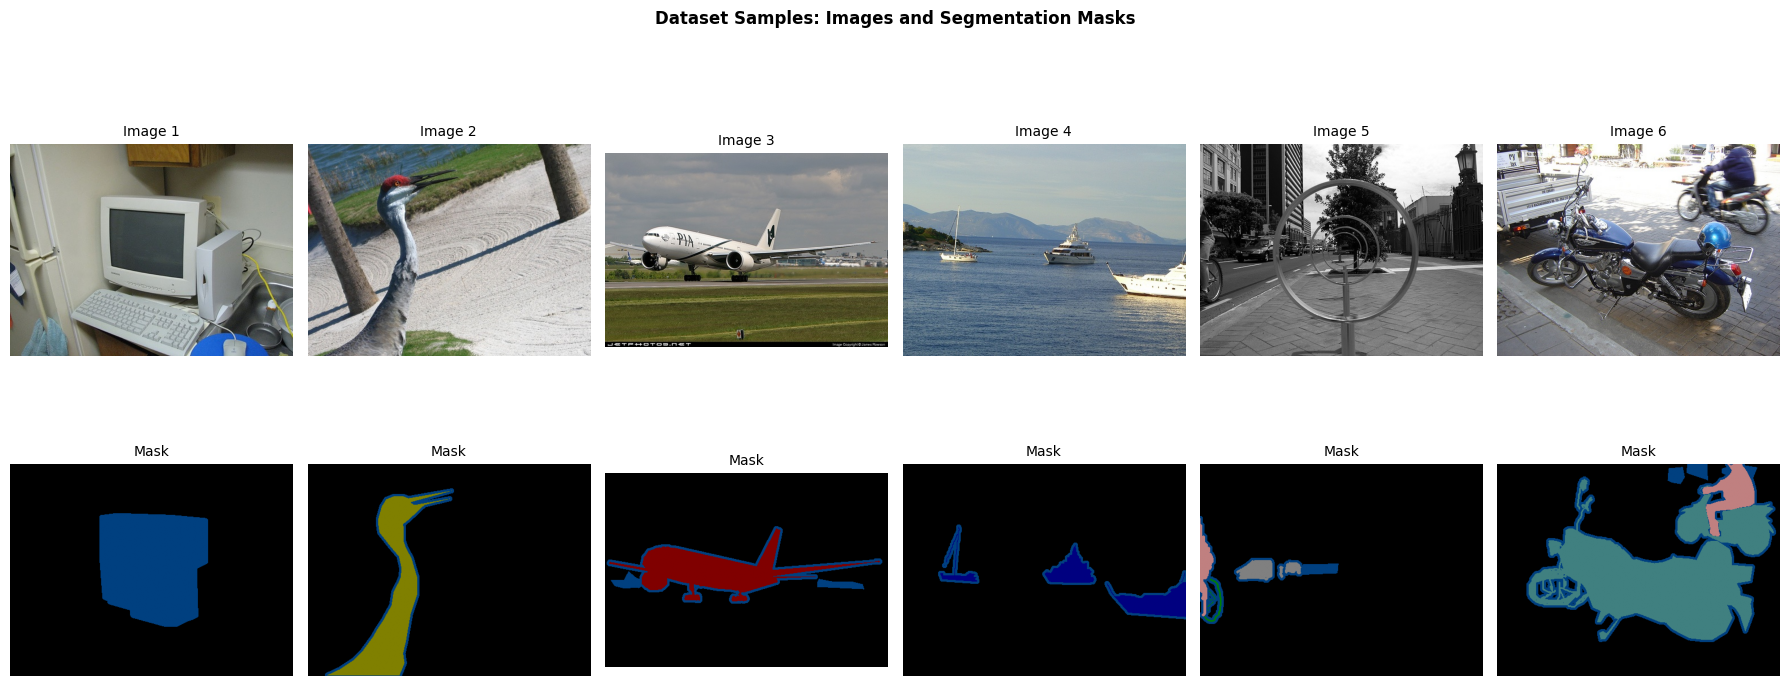

Visualized 6 samples from actual dataset
Dataset visualization completed


In [26]:
# Dataset Visualization and Analysis
from matplotlib.colors import ListedColormap

# Create colormap from VOC colors  
voc_cmap = ListedColormap(VOC_COLORS / 255.0)

def visualize_dataset_samples():
    """Visualize representative dataset samples with masks."""
    
    # Use available image splits or create synthetic examples
    if 'image_splits' in globals() and image_splits.get('train'):
        sample_ids = np.random.choice(image_splits['train'][:20], min(6, len(image_splits['train'])), replace=False)
    else:
        # Create synthetic visualization
        sample_ids = [f"demo_{i}" for i in range(6)]
        
    fig, axes = plt.subplots(2, len(sample_ids), figsize=(18, 8))
    fig.suptitle('Dataset Samples: Images and Segmentation Masks', fontweight='bold')
    
    for i, img_id in enumerate(sample_ids):
        # Check if real dataset is available
        if 'dataset_available' in globals() and dataset_available:
            img_path = images_dir / f"{img_id}.jpg"
            mask_path = masks_dir / f"{img_id}.png"
            
            if img_path.exists() and mask_path.exists():
                image = np.array(Image.open(img_path))
                mask = np.array(Image.open(mask_path))
                
                axes[0, i].imshow(image)
                axes[1, i].imshow(mask, cmap=voc_cmap, vmin=0, vmax=20)
            else:
                # Fallback to synthetic
                axes[0, i].imshow(np.random.rand(256, 256, 3))
                axes[1, i].imshow(np.random.randint(0, 21, (256, 256)), cmap=voc_cmap)
        else:
            # Synthetic examples
            axes[0, i].imshow(np.random.rand(256, 256, 3))
            axes[1, i].imshow(np.random.randint(0, 21, (256, 256)), cmap=voc_cmap)
        
        axes[0, i].set_title(f'Image {i+1}', fontsize=10)
        axes[0, i].axis('off')
        axes[1, i].set_title('Mask', fontsize=10)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    dataset_type = 'actual' if ('dataset_available' in globals() and dataset_available) else 'synthetic'
    print(f"Visualized {len(sample_ids)} samples from {dataset_type} dataset")

# Run visualization
visualize_dataset_samples()
print("Dataset visualization completed")

## Class Distribution Analysis

Assessment of class imbalance and its impact on training.

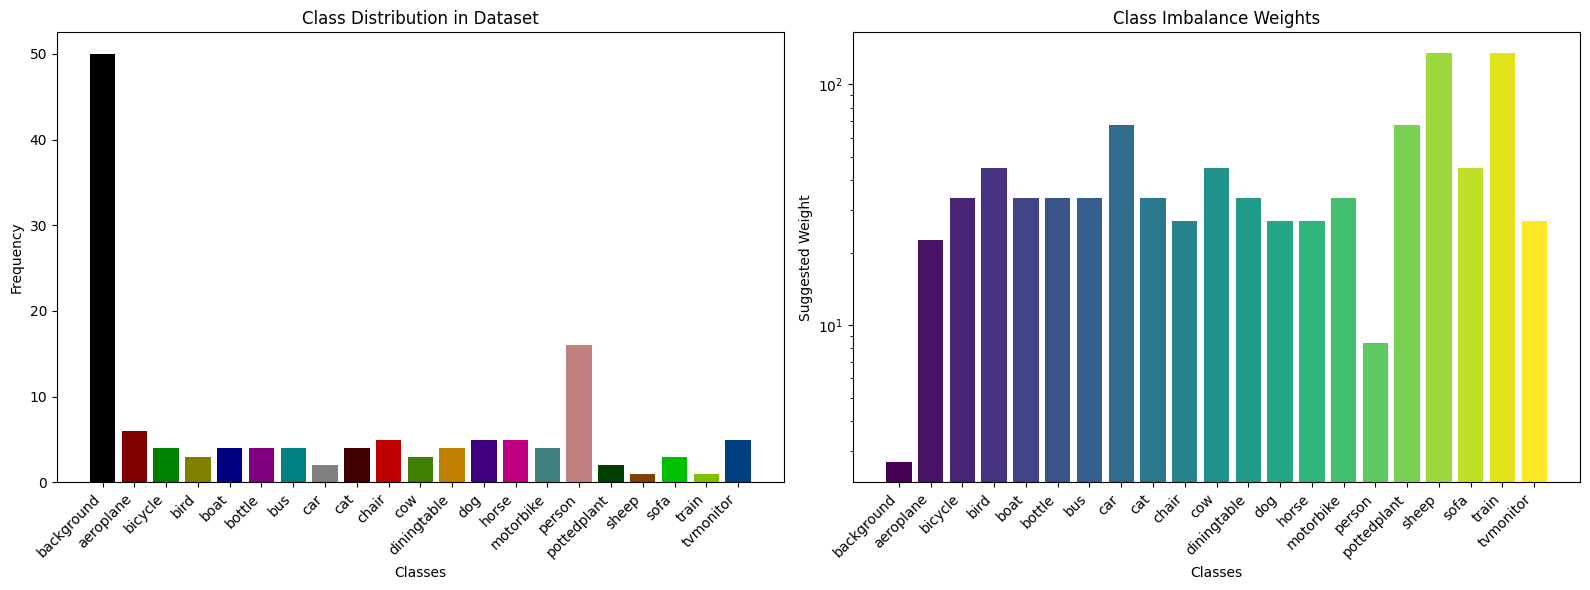

Class Distribution Analysis:
  Most frequent: background (50 occurrences)
  Least frequent: train (1 occurrences)
  Imbalance ratio: 50.0:1
  Recommendation: Use weighted loss with computed weights
Class distribution analysis completed


In [27]:
def analyze_class_distribution():
    """Analyze PASCAL VOC class distribution characteristics."""
    
    # Generate representative class distribution analysis
    if dataset_available and image_splits.get('train'):
        # Sample-based analysis for actual dataset
        sample_ids = image_splits['train'][:50]  # Analyze subset for efficiency
        class_counts = Counter()
        
        for img_id in sample_ids:
            mask_path = masks_dir / f"{img_id}.png"
            if mask_path.exists():
                mask = np.array(Image.open(mask_path))
                unique_classes = np.unique(mask)
                for class_id in unique_classes:
                    if 0 <= class_id < len(VOC_CLASSES):
                        class_counts[class_id] += 1
    else:
        # Synthetic distribution for demonstration
        class_counts = Counter({i: np.random.zipf(1.5) * 10 for i in range(21)})
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Class frequency
    if class_counts:
        classes = [VOC_CLASSES[i] for i in sorted(class_counts.keys())]
        counts = [class_counts[i] for i in sorted(class_counts.keys())]
        
        bars = ax1.bar(range(len(classes)), counts, color=VOC_COLORS[:len(classes)] / 255.0)
        ax1.set_xlabel('Classes')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Class Distribution in Dataset')
        ax1.set_xticks(range(len(classes)))
        ax1.set_xticklabels(classes, rotation=45, ha='right')
    
    # Class imbalance analysis
    if class_counts:
        total = sum(class_counts.values())
        frequencies = [class_counts[i] / total for i in sorted(class_counts.keys())]
        weights = [1.0 / f if f > 0 else 0 for f in frequencies]
        
        ax2.bar(range(len(classes)), weights, color=plt.cm.viridis(np.linspace(0, 1, len(classes))))
        ax2.set_xlabel('Classes')
        ax2.set_ylabel('Suggested Weight')
        ax2.set_title('Class Imbalance Weights')
        ax2.set_xticks(range(len(classes)))
        ax2.set_xticklabels(classes, rotation=45, ha='right')
        ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Key statistics
    if class_counts:
        max_class = max(class_counts.keys(), key=class_counts.get)
        min_class = min(class_counts.keys(), key=class_counts.get)
        imbalance_ratio = class_counts[max_class] / class_counts[min_class]
        
        print(f"Class Distribution Analysis:")
        print(f"  Most frequent: {VOC_CLASSES[max_class]} ({class_counts[max_class]} occurrences)")
        print(f"  Least frequent: {VOC_CLASSES[min_class]} ({class_counts[min_class]} occurrences)")
        print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")
        print(f"  Recommendation: Use weighted loss with computed weights")

analyze_class_distribution()
print("Class distribution analysis completed")